In [1]:
# TensorFlow and tf.keras
# import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
import pandas as pd

import keras
from keras import layers
import keras.backend
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
import keras.models
import keras.utils

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import h5py
import sklearn
import os

Using TensorFlow backend.


In [25]:
traindata = np.load('train_data.npz')
testdata = np.load('test_data.npz')
trainimages = traindata['circles']
grid = np.sqrt(trainimages[0,:].size).astype(int)
testimages = testdata['circles']
trainlabels = traindata['labels']
testlabels = testdata['labels']
n_test = len(testlabels)
n_train = len(trainlabels)
trainimages = trainimages.reshape(n_train, grid, grid, 1)
testimages = testimages.reshape(n_test, grid, grid, 1)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]



 Summed signal image:



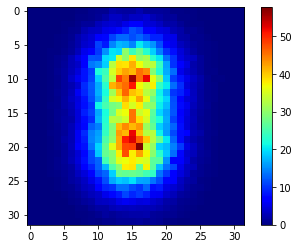


 Summed background image:



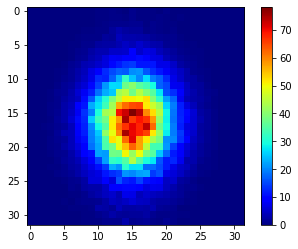

In [3]:
#plot input signal and background
sig_trainimages = np.zeros_like(trainimages[1])
bkg_trainimages = np.zeros_like(trainimages[1])
for i in range(len(trainimages)):
    if testlabels[i] == 1:
        sig_trainimages += trainimages[i]
    else:
        bkg_trainimages += trainimages[i]
#signal
print('\n Summed signal image:\n')
display_sig = sig_trainimages.reshape(grid,grid)
plt.figure()
plt.grid(False)
plt.imshow(display_sig, cmap = 'jet')
plt.colorbar()
plt.show()
print('\n Summed background image:\n')
display_bkg = bkg_trainimages.reshape(grid,grid)
plt.figure()
plt.grid(False)
plt.imshow(display_bkg, cmap = 'jet')
plt.colorbar()
plt.show()

In [4]:
# !ls training
best_model = keras.models.load_model('training/CNN_sparce_cat.h5')
best_model.summary()
results = best_model.evaluate(testimages, testlabels)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 22, 32)        3904      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
______________________

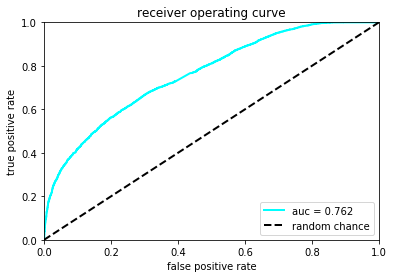

In [5]:
# Plot ROC
predict = best_model.predict(testimages)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels, predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

In [6]:
import innvestigate
import innvestigate.utils as iutils

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


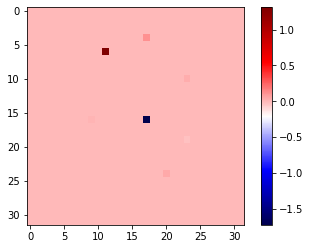

In [7]:
# Creating an analyzer
lrp_analyzer = innvestigate.create_analyzer("lrp.z", best_model)
#discoverered that innvestigate fails to run on a loaded model --> trying to find fix

# Applying the analyzer
display = trainimages[1].reshape(1,grid,grid,1) #the reshape is this way is because the input is expected to be 4 dimensions
analysis = lrp_analyzer.analyze(display)

# Displaying one result
plt.imshow(analysis.squeeze(), cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.show()

5000


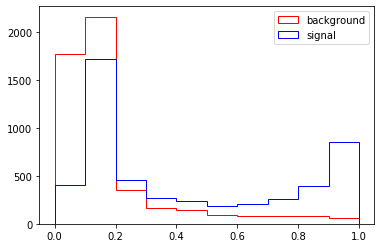

In [28]:
hist, bin_edges = np.histogram(predict[:int(len(predict)/2)])
hist_, bin_edges_ = np.histogram(predict[:-int(len(predict)/2)])
print(int(len(predict)/2))
plt.hist([predict[:int(len(predict)/2)].flatten(), predict[int(len(predict)/2):-1].flatten()] ,
         color = ['blue', 'red'], histtype = 'step', label = ['signal', 'background'])
plt.legend()
plt.show()

In [43]:
#fix - change to predicted labels
#plot output signal and background
sig_analysis_true = np.zeros_like(analysis)
bkg_analysis_true = np.zeros_like(analysis)
sig_analysis_pred = np.zeros_like(analysis)
bkg_analysis_pred = np.zeros_like(analysis)
sig_inefficiency = np.zeros_like(analysis)
bkg_inefficiency = np.zeros_like(analysis)
# sig_mask = trainlabels == 1
# bkg_mask = trainlabels == 0
# pred_sig_mask = predict >= 0.50
# pred_bkg_mask = predict < 0.50

toc = time.time()

for i in range(len(trainimages)):
    display = trainimages[i].reshape(1,grid,grid,1)
    analysis = lrp_analyzer.analyze(display)
    if trainlabels[i] == 1:
        sig_analysis_true += analysis  
    else:
        bkg_analysis_true += analysis

for i in range(len(trainimages)):
    display = trainimages[i].reshape(1,grid,grid,1)
    analysis = lrp_analyzer.analyze(display)
    if i >= int(len(predict)/2) and predict[i] >= 0.50:
        sig_analysis_pred += analysis
    elif i >= int(len(predict)/2) and predict[i] < 0.50:
        sig_inefficiency += analysis
    elif i < int(len(predict)/2) and predict[i] < 0.50:
        bkg_analysis_pred += analysis
    else:
        bkg_inefficiency += analysis

tic = time.time()

print('/n time = /n', tic-toc)


/n time = /n 66.16571640968323


Signal inefficiency for true values:


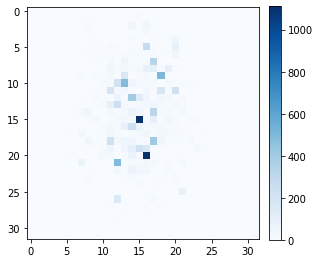

Background inefficiency heatmap for predicted values:


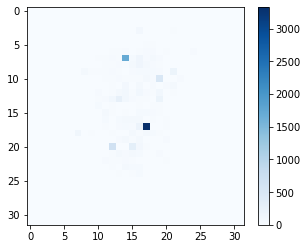

In [44]:
# Displaying the signal result
ax = plt.figure(figsize = (10,10))
print('Signal inefficiency for true values:')
ax.add_subplot(121)
im = plt.imshow(np.absolute(sig_inefficiency.squeeze()), cmap='Blues', interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()
print('Background inefficiency heatmap for predicted values:')
ax.add_subplot(122)
im_ = plt.imshow(np.absolute(bkg_inefficiency.squeeze()), cmap='Blues', interpolation='nearest')
plt.colorbar(im_,fraction=0.046, pad=0.04)
plt.show()

Signal heatmap for true values:


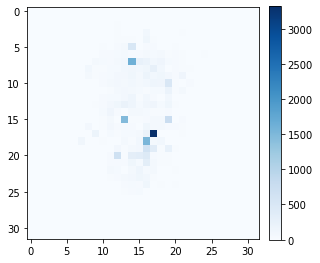

Signal heatmap for predicted values:


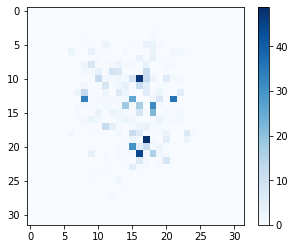

In [45]:
# Displaying the signal result
ax = plt.figure(figsize = (10,10))
print('Signal heatmap for true values:')
ax.add_subplot(121)
im = plt.imshow(np.absolute(sig_analysis_true.squeeze()), cmap='Blues', interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()
print('Signal heatmap for predicted values:')
ax.add_subplot(122)
im_ = plt.imshow(np.absolute(sig_analysis_pred.squeeze()), cmap='Blues', interpolation='nearest')
plt.colorbar(im_,fraction=0.046, pad=0.04)
plt.show()

#make ROC curve for different values of signal background "size" aka spread

Background heatmap for true values:


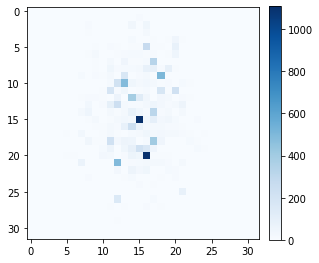

Background heatmap for predicted values:


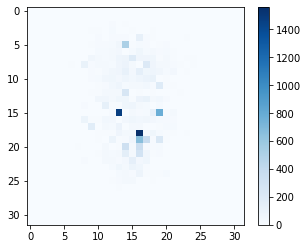

In [47]:
# Displaying the background result
ax = plt.figure(figsize = (10,10))
print('Background heatmap for true values:')
ax.add_subplot(121)
im_ = plt.imshow(np.absolute(bkg_analysis_true.squeeze()), cmap='Blues', interpolation='nearest')
plt.colorbar(im_,fraction=0.046, pad=0.04)
plt.show()
print('Background heatmap for predicted values:')
ax.add_subplot(122)
im = plt.imshow(np.absolute(bkg_analysis_pred.squeeze()), cmap='Blues', interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()